In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
from matplotlib import pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

mnist_train = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

mnist_test = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(110, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, 784)
    
    # forward method
    def forward(self, x): 
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 11)
    
    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.5)
        x = F.leaky_relu(self.fc4(x), 0.2)
        return x

In [3]:
p_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
r_list = [1]

# No of correct classification for each type for each p_value
correct = np.zeros((7, 10))

# Total no of samples of each type for each p_value
total = np.zeros((7, 10))

for r in r_list :
    for i, p in enumerate(p_list) :
        D = Discriminator().to(device)
        D.load_state_dict(torch.load(f'./models/mnist_r_value_{r}_p_value_{p}.pt'))
        D.eval()

        with torch.no_grad():
            for sample in mnist_test :
                input_image = sample[0].view(-1, 784)
                output_value = D(input_image.to(device))
                output_value = output_value.cpu().detach().numpy().reshape(11)
                output_value = output_value[:10]
                output_value = np.argmax(output_value)

                if(output_value == sample[1]) :
                    correct[i][sample[1]] += 1
                
                total[i][sample[1]] += 1

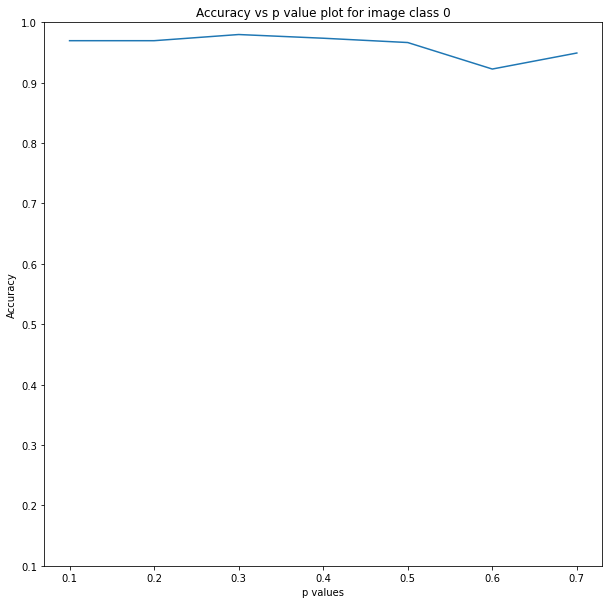

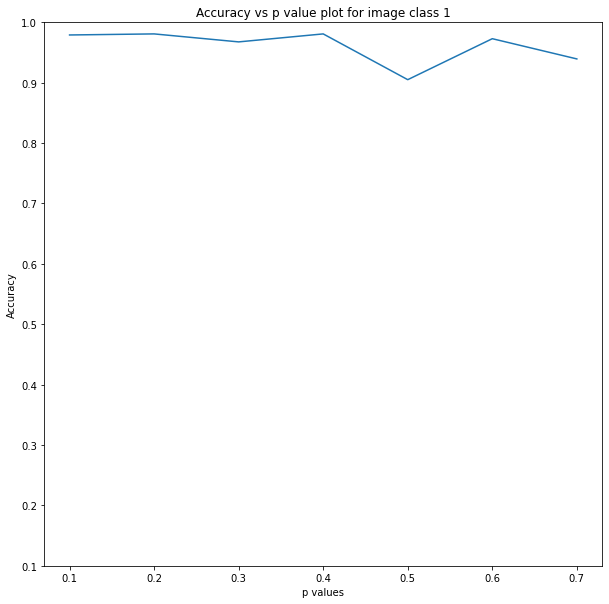

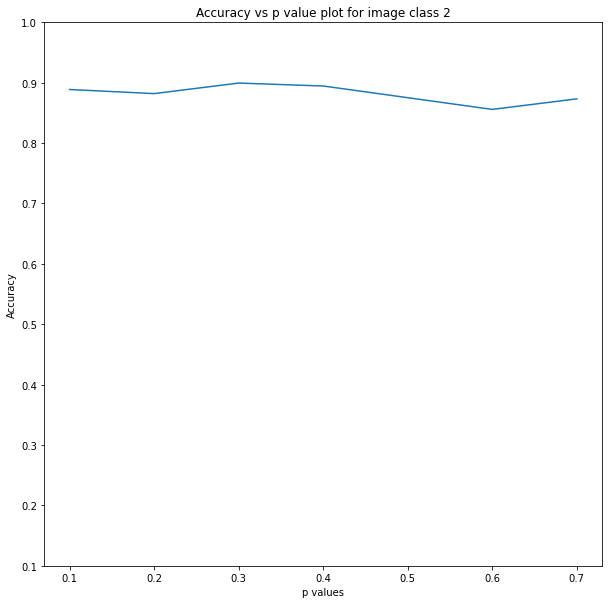

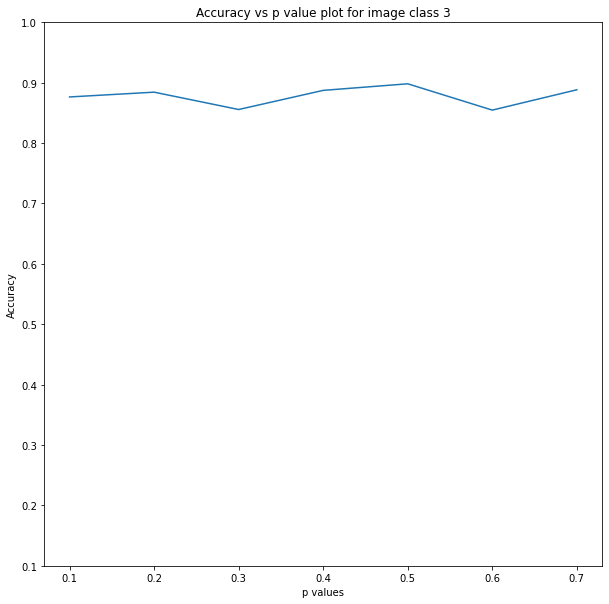

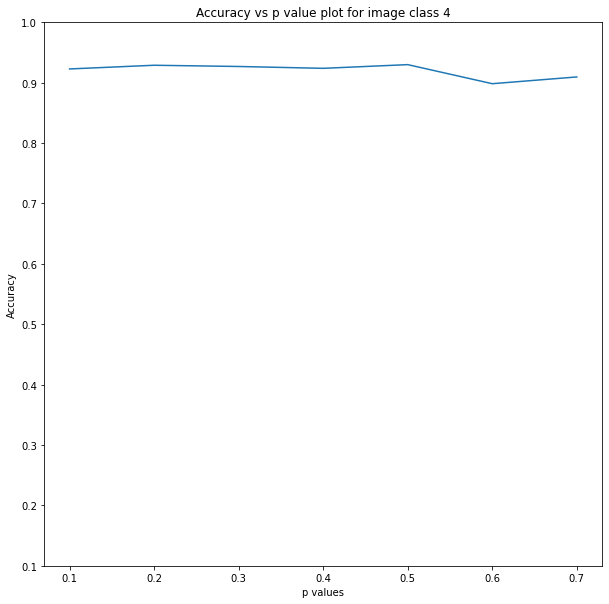

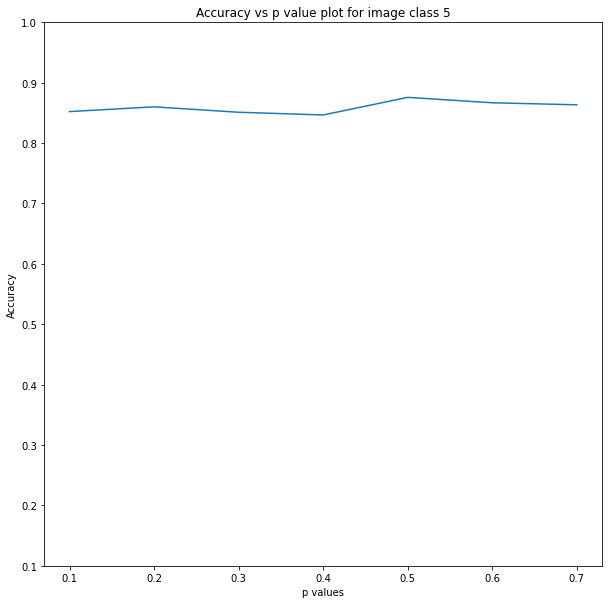

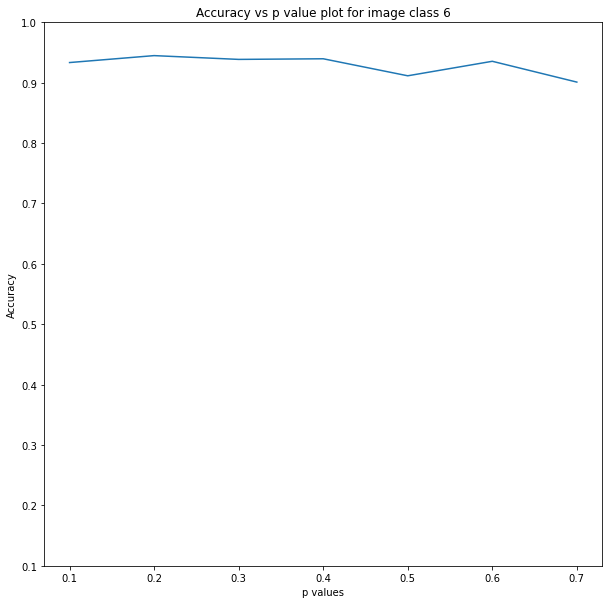

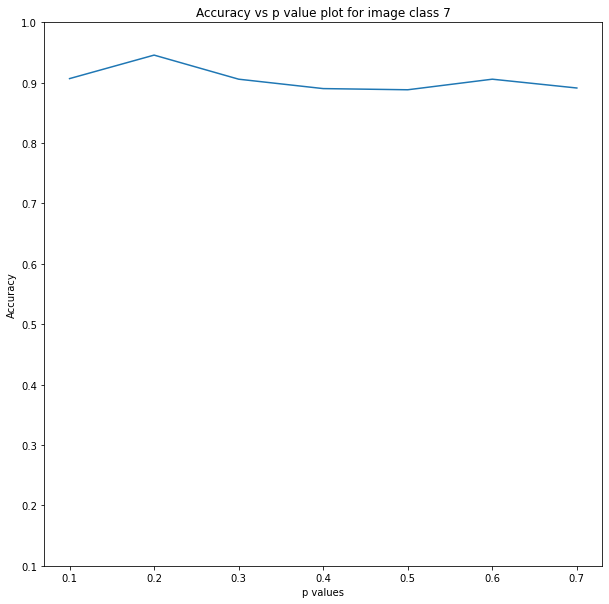

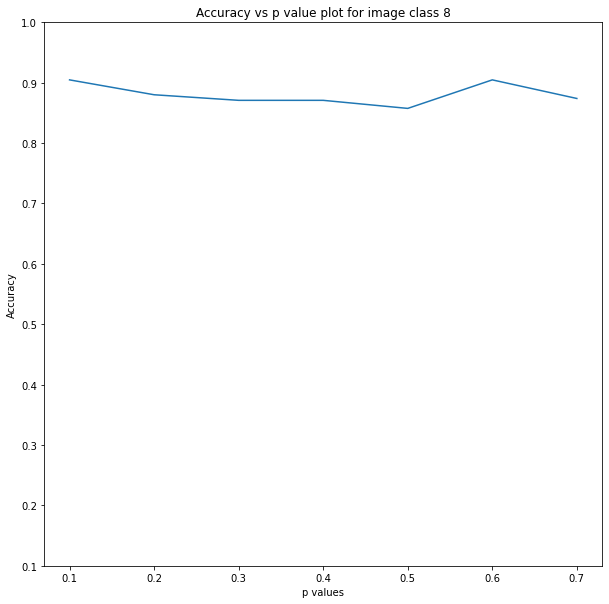

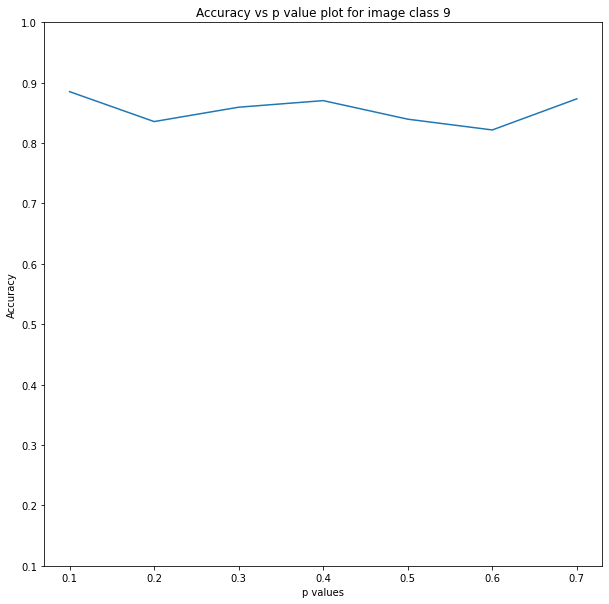

In [4]:
for i in range(10) :
    plt.figure(figsize=[10, 10])
    plt.plot(np.arange(0.1, 0.8, 0.1), correct[:, i]/total[:, i])
    plt.ylabel('Accuracy')
    plt.xlabel('p values')
    plt.title(f'Accuracy vs p value plot for image class {i}')
    plt.ylim(0.1, 1)
    plt.show()